This notebook introduces the problem addressed in this paper:

 - localizating an object in a large image
 - foveation
 - action (saccade)
 

In [1]:
figname = '../paper/fig_result'

In [2]:
%run 0_parameters.ipynb


This notebook introduces the problem addressed in this paper:

 - localizating an object in a large image
 - foveation
 - action (saccade)
       
      
2019-03-15
{'w': 28, 'minibatch_size': 100, 'train_batch_size': 60000, 'test_batch_size': 1000, 'noise_batch_size': 1000, 'mean': 0.1307, 'std': 0.3081, 'N_pic': 128, 'offset_std': 30, 'offset_max': 35, 'noise': 1.0, 'contrast': 0.8, 'sf_0': 0.2, 'B_sf': 0.3, 'N_theta': 6, 'N_azimuth': 16, 'N_eccentricity': 10, 'N_phase': 2, 'N_X': 128, 'N_Y': 128, 'rho': 1.41, 'bias_deconv': True, 'p_dropout': 0.5, 'dim1': 1000, 'dim2': 1000, 'loss_func': BCEWithLogitsLoss(), 'lr': 0.0001, 'do_adam': True, 'epochs': 40, 'bn1_bn_momentum': 0.0, 'bn2_bn_momentum': 0.0, 'momentum': 0.1, 'n_epochs': 10, 'num_processes': 1, 'no_cuda': True, 'log_interval': 100, 'verbose': 1, 'filename': '../data/2019-03-15', 'seed': 2019}
Overwriting train.py
2019-03-15T13:50:59+01:00

CPython 3.7.2
IPython 7.3.0

numpy 1.16.2
matplotlib 3.0.3
torch 1.0.1.post2

compiler

# Training the Where network

In [3]:
from retina import Display
d = Display(args)

from retina import Retina
r = Retina(args)

from where import Where
where = Where(args, d, r)

filename_train = args.filename + '_train.pt'
filename_train = "../data/2019-03-14_train4.pt"
%ls -lh {filename_train}
#%rm {filename_train}

where.train(filename_train)

Loading accuracy... min, max= 0.0145 0.9852
-rw-r--r--  1 laurentperrinet  staff    12M Mar 14 19:28 ../data/2019-03-14_train4.pt
Loading file ../data/2019-03-14_train4.pt


/usr/local/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'where.WhereNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


# Visualisation of some examples

In [4]:
data, label = next(iter(d.loader_test))
idx_start, idx_stop = 0, 11

full, retina_data, accuracy_colliculus = where.minibatch(data)

## knowing the target position

In [5]:
im = np.zeros((args.test_batch_size, args.w, args.w))
for idx in range(args.test_batch_size):
    im[idx, :, :] = where.extract(full[idx]['data_fullfield'], full[idx]['i_offset'], full[idx]['j_offset'])
proba = where.classify_what(im).numpy()
pred = proba.argmax(axis=1) # get the index of the max log-probability
#acc = proba[:, pred]
acc_max = (pred==label.numpy()).mean()
print('Accuracy max (knowing the mosition)=', acc_max)

Accuracy max (knowing the mosition)= 0.892


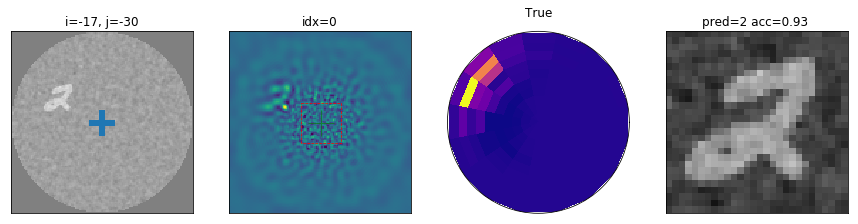

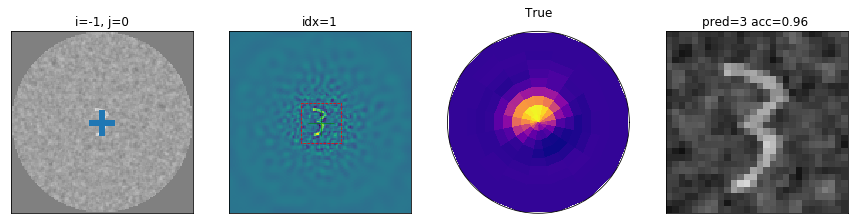

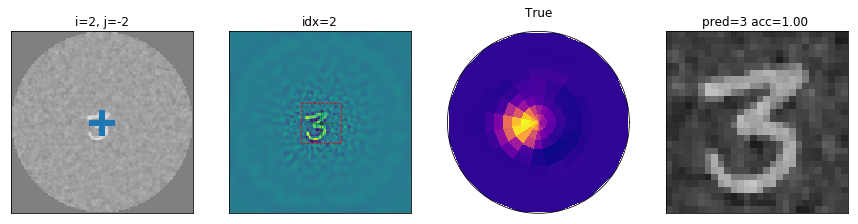

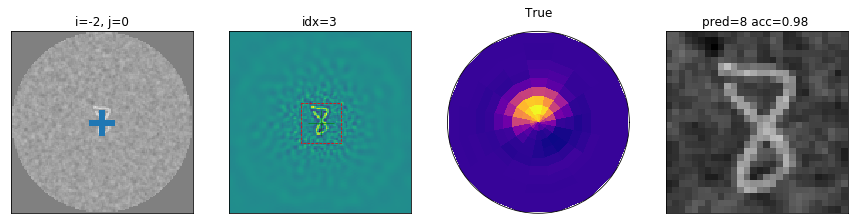

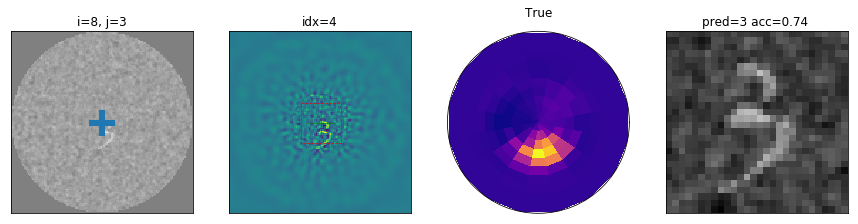

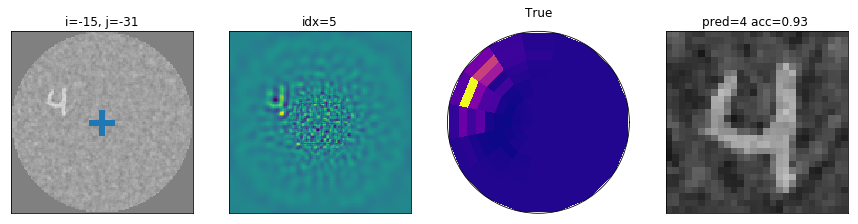

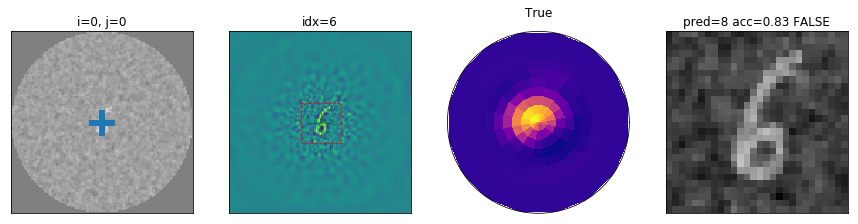

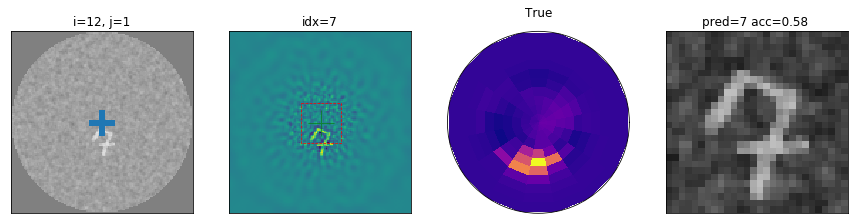

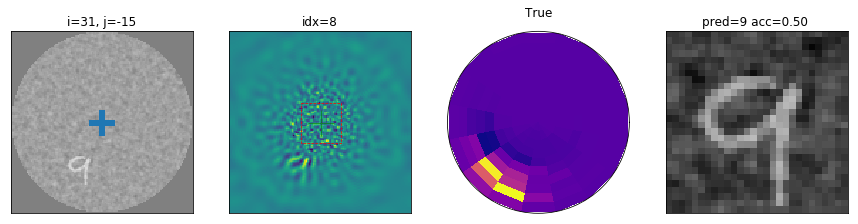

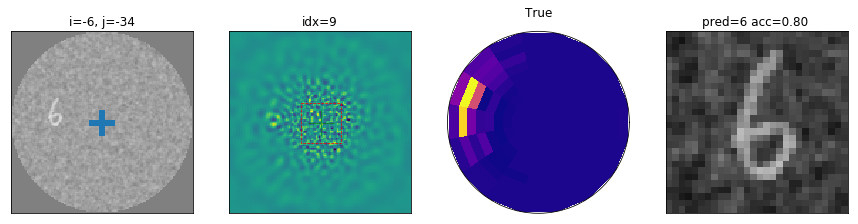

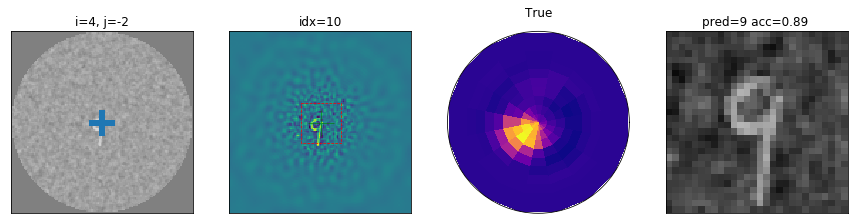

In [6]:
for idx in range(idx_start, idx_stop):
    fig = plt.figure(figsize = (15, 8))
    
    ax = fig.add_subplot(141)
    ax = d.show(ax, full[idx]['data_fullfield'])
    ax.set_title(f"i={full[idx]['i_offset']}, j={full[idx]['j_offset']}")
    
    ax = fig.add_subplot(142)
    data_retina = r.retina(full[idx]['data_fullfield'])
    ax = r.show(ax, r.retina_invert(data_retina))
    ax.set_title(f"idx={idx}")
              
    ax = fig.add_subplot(143, projection='polar')
    ax.pcolor(r.theta, r.log_r, accuracy_colliculus[idx, :].numpy().reshape((args.N_azimuth, args.N_eccentricity)), cmap=plt.plasma())
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title("True")

    ax = fig.add_subplot(144)
    ax = d.show(ax, im[idx, :, :], do_cross=False)
    result = '' if pred[idx]==label[idx].numpy() else 'FALSE'
    ax.set_title(f"pred={pred[idx]} acc={proba[idx,pred[idx]]:.2f} {result}")
                 

## predicting the position of the target

In [7]:
pred_accuracy_colliculus = where.pred_accuracy(retina_data)
print('pred_accuracy_colliculus.shape=', pred_accuracy_colliculus.shape)

pred_accuracy_colliculus.shape= (1000, 160)


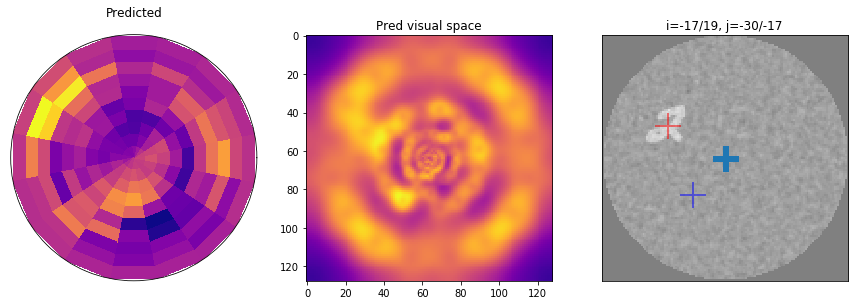

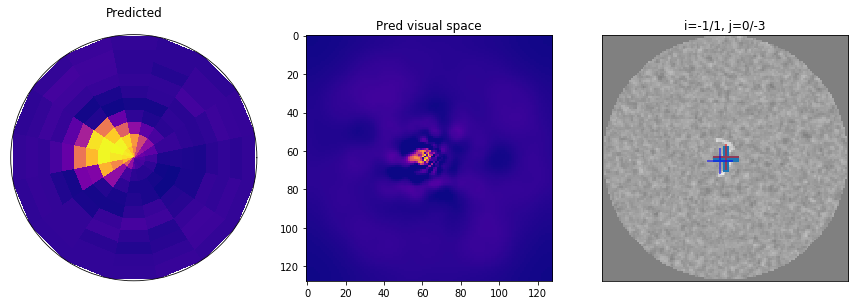

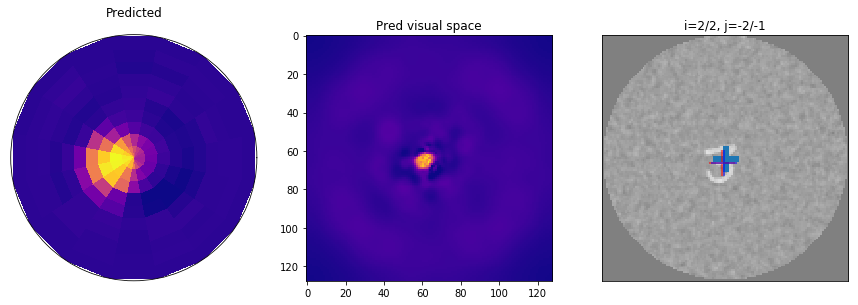

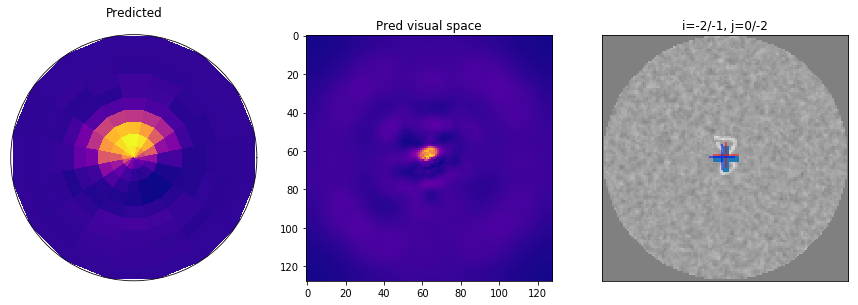

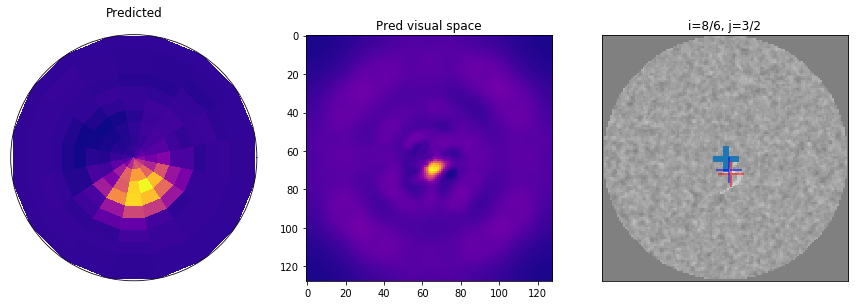

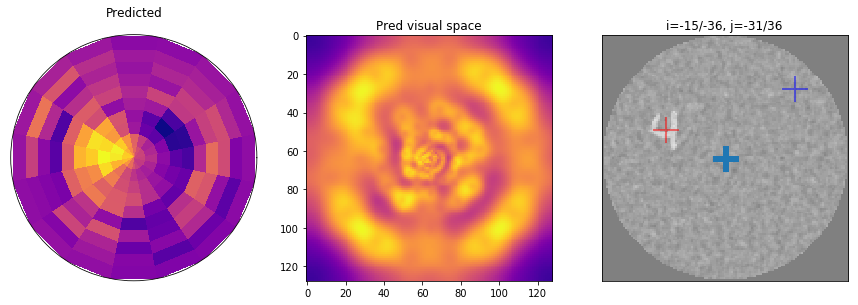

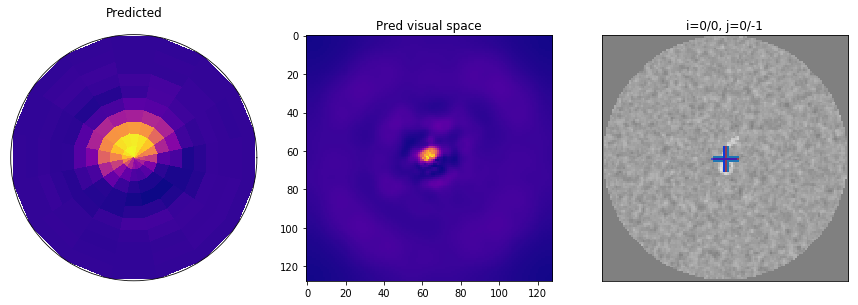

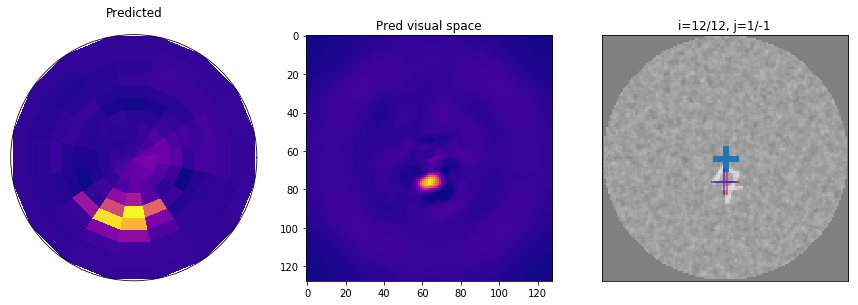

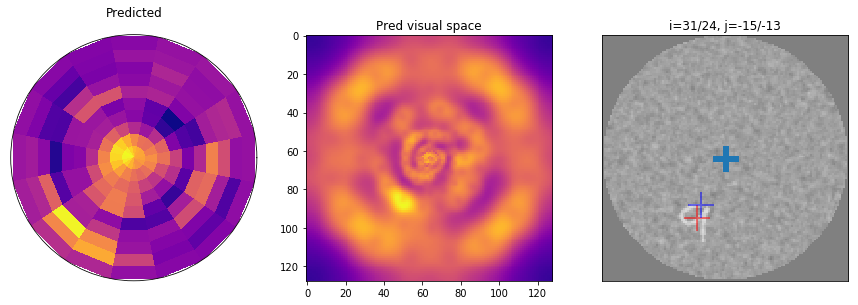

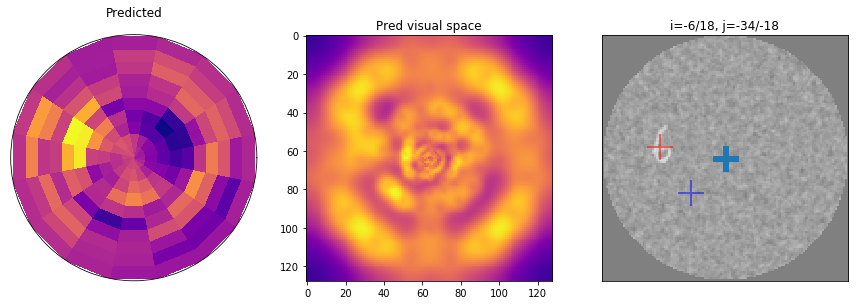

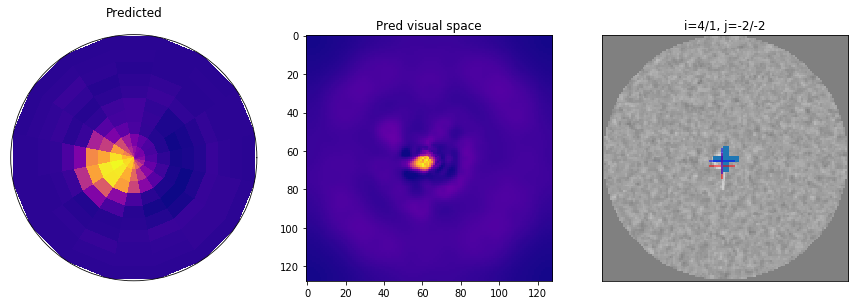

In [8]:
for idx in range(idx_start, idx_stop):
    fig = plt.figure(figsize = (15, 8))

    ax = fig.add_subplot(131, projection='polar')
    ax.pcolor(r.theta, r.log_r, pred_accuracy_colliculus[idx, :].reshape((args.N_azimuth, args.N_eccentricity)), cmap=plt.plasma())
    ax.set_title("Predicted")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
              
    x = r.accuracy_invert(pred_accuracy_colliculus[idx, :])
    ax = fig.add_subplot(132)
    ax.imshow(x, vmin=0, cmap=plt.plasma())
    ax.set_title("Pred visual space")
    
    i, j = np.unravel_index(np.argmax(x.ravel()), x.shape)
    i_pred = i - args.N_pic//2
    j_pred = j - args.N_pic//2
    ax = fig.add_subplot(133)
    ax = d.show(ax, full[idx]['data_fullfield'])
    ax.set_title(f"i={full[idx]['i_offset']}/{i_pred}, j={full[idx]['j_offset']}/{j_pred}")
    ax.plot([full[idx]['j_offset']+args.N_pic//2], [full[idx]['i_offset']+args.N_pic//2], '+', c='r', ms=26, markeredgewidth=2, alpha=.5)
    ax.plot([j], [i], '+', c='b', ms=26, markeredgewidth=2, alpha=.5)
    
    

## doing a saccade at the predicted the position of the target

In [9]:
accuracy = where.test_what(full, pred_accuracy_colliculus, label)
print('mean accuracy =', accuracy.mean())

mean accuracy = 0.518


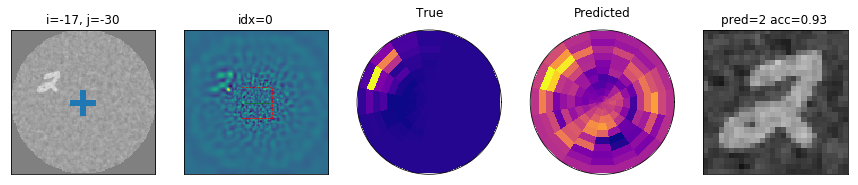

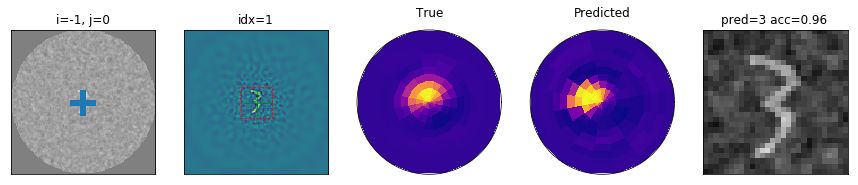

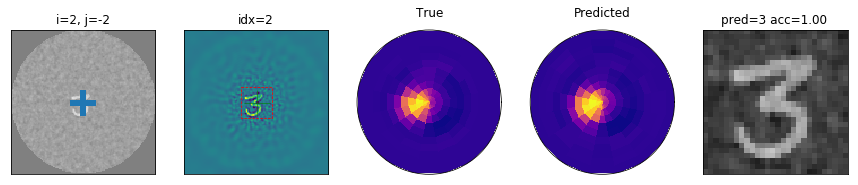

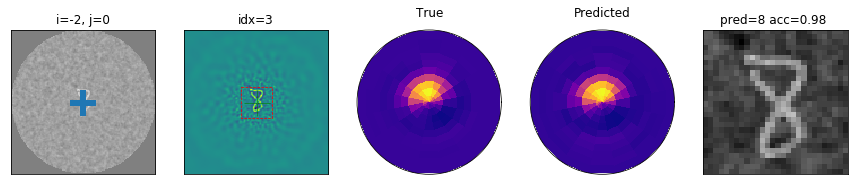

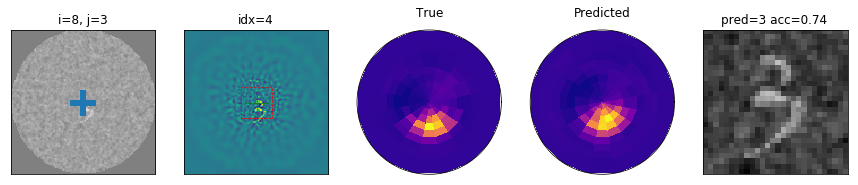

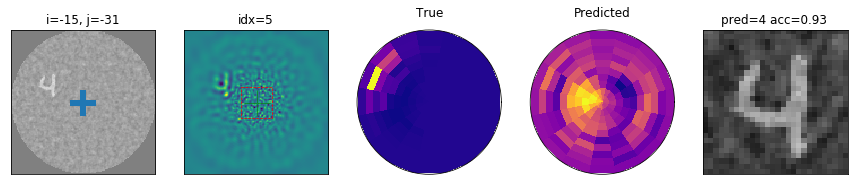

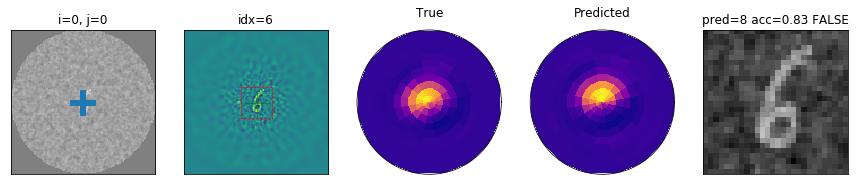

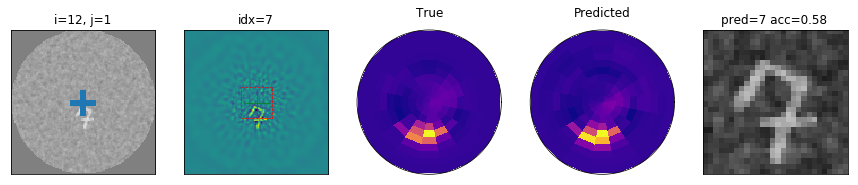

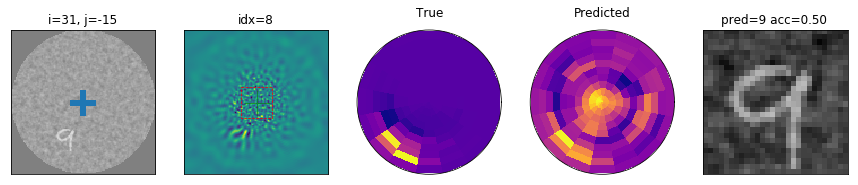

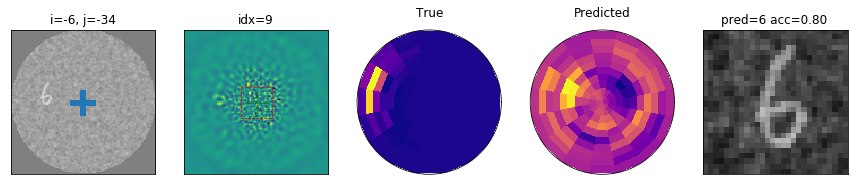

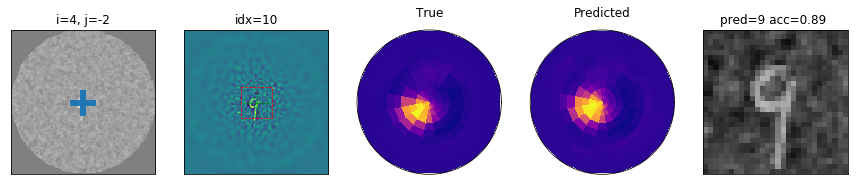

In [10]:
for idx in range(idx_start, idx_stop):
    fig = plt.figure(figsize = (15, 8))
    
    ax = fig.add_subplot(151)
    ax = d.show(ax, full[idx]['data_fullfield'])
    ax.set_title(f"i={full[idx]['i_offset']}, j={full[idx]['j_offset']}")
    
    ax = fig.add_subplot(152)
    data_retina = r.retina(full[idx]['data_fullfield'])
    ax = r.show(ax, r.retina_invert(data_retina))
    ax.set_title(f"idx={idx}")
              
    ax = fig.add_subplot(153, projection='polar')
    ax.pcolor(r.theta, r.log_r, accuracy_colliculus[idx, :].numpy().reshape((args.N_azimuth, args.N_eccentricity)), cmap=plt.plasma())
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title("True")

    ax = fig.add_subplot(154, projection='polar')
    ax.pcolor(r.theta, r.log_r, pred_accuracy_colliculus[idx, :].reshape((args.N_azimuth, args.N_eccentricity)), cmap=plt.plasma())
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title("Predicted")

    ax = fig.add_subplot(155)
    ax = d.show(ax, im[idx, :, :], do_cross=False)
    result = '' if pred[idx]==label[idx].numpy() else 'FALSE'
    ax.set_title(f"pred={pred[idx]} acc={proba[idx,pred[idx]]:.2f} {result}")
                 

testing on the test set:

In [11]:
where.test()

0.5103000000000001

# accuracy as a function of eccentricity


In [12]:
def test_eccentricities(N_eccentricities=9, ecc_max=.8):
     
    #eccentricities = args.N_pic / 2 * ecc_max * (1/args.rho)**(args.N_eccentricity - np.arange(N_eccentricities))
    eccentricities = np.linspace(where.args.offset_max, 0, N_eccentricities, endpoint=False)
    
    accuracy_mean, accuracy_std = [], []
    for eccentricity in eccentricities:
        data, label = next(iter(d.loader_test))

        batch_size = data.shape[0]
        retina_data = np.zeros((batch_size, where.retina.vsize))
        accuracy_colliculus = np.zeros((batch_size, where.args.N_azimuth * where.args.N_eccentricity))
        full =[]

        for i in range(batch_size):
            data_fullfield, i_offset, j_offset = where.display.draw(data[i, 0, :, :].numpy(), 
                                                                   radius=eccentricity)
            full.append(dict(data_fullfield=data_fullfield, i_offset=i_offset, j_offset=j_offset))
            retina_data[i, :]  =  where.retina.retina(data_fullfield)

        pred_accuracy_colliculus = where.pred_accuracy(retina_data)
        accuracy_ = where.test_what(full, pred_accuracy_colliculus, label)
        accuracy_mean.append(accuracy_.mean())
        accuracy_std.append(accuracy_.std()) # TODO fit with beta distribution
        
    return eccentricities, np.array(accuracy_mean), np.array(accuracy_std)

N_eccentricities = 9
eccentricities, accuracy_mean, accuracy_std = test_eccentricities(N_eccentricities)
print('eccentricities=', eccentricities, ', accuracy_data=', accuracy_mean, ' +/- ', accuracy_std)

eccentricities= [35.         31.11111111 27.22222222 23.33333333 19.44444444 15.55555556
 11.66666667  7.77777778  3.88888889] , accuracy_data= [0.162 0.386 0.462 0.505 0.56  0.665 0.698 0.624 0.679]  +/-  [0.36845081 0.48683057 0.49855391 0.499975   0.49638695 0.47199047
 0.45912526 0.48438002 0.46686079]


(0, 1)

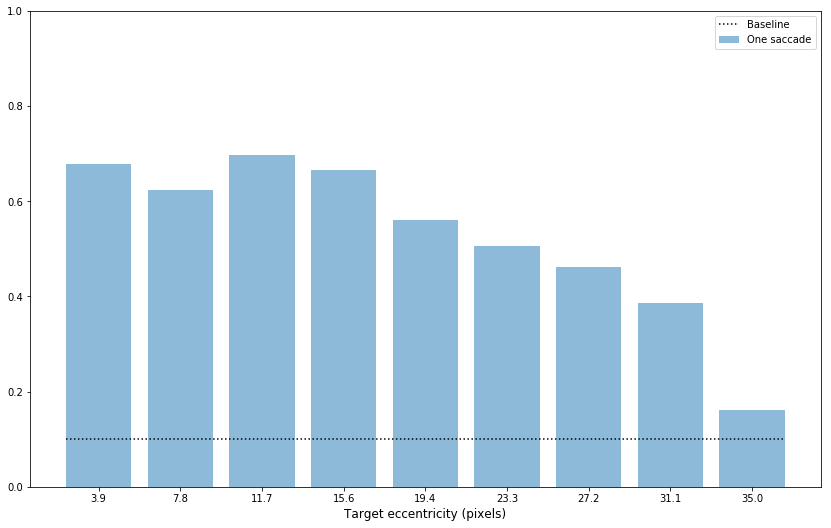

In [13]:
fig = plt.figure(figsize = (figwidth, figwidth/1.618))
ax_D = fig.add_subplot(1, 1, 1)
width = .8*np.abs(np.gradient(eccentricities)[0])
ax_D.bar(eccentricities, accuracy_mean, width=width, alpha = .5, label = 'One saccade')#yerr=accuracy_std, 
# TODO what instead? ax_D.bar(eccentricities, accuracy_data, alpha = .5, label = 'No saccade') #accuracy_map[27,27:55])
ax_D.plot([eccentricities.min()-width/2, eccentricities.max()+width/2], [0.1]*2, ':', c='k', label = 'Baseline')
plt.legend(loc='best')
#ax_D.set_title('Class accuracy', fontsize = 14)
ax_D.set_xlabel('Target eccentricity (pixels)', fontsize = 12)
ax_D.set_xticks(eccentricities)
ax_D.set_xticklabels(['%.1f' % d for  d in eccentricities])
ax_D.set_ylim([0,1])

# summary


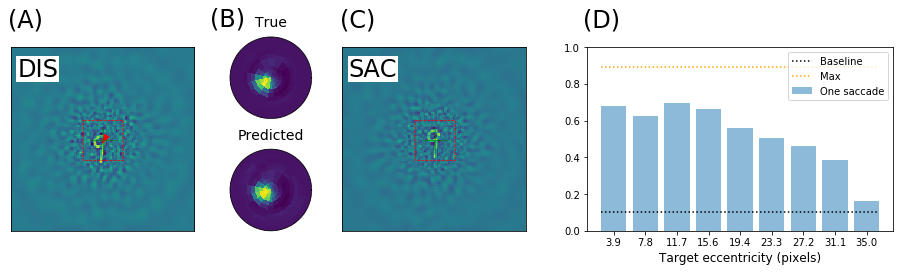

In [14]:
fig = plt.figure(figsize = (figwidth, figwidth/2.5))#1.618))
ax_A = plt.subplot(1, 4, 1) 
data_retina = r.retina(full[idx]['data_fullfield'])
ax_A = where.retina.show(ax_A, r.retina_invert(data_retina))
    
ax_B = plt.subplot(2, 4, 2, projection='polar', autoscale_on=False)
ax_B.pcolor(r.theta, r.log_r, accuracy_colliculus[idx, :].numpy().reshape((args.N_azimuth, args.N_eccentricity)))
ax_B.grid('off')
plt.title('True', fontsize = 14)
ax_B.set_yticklabels([])
ax_B.set_xticklabels([])

ax_Bb = plt.subplot(2, 4, 6, projection='polar')
ax_Bb.pcolor(r.theta, r.log_r, pred_accuracy_colliculus[idx, :].reshape((args.N_azimuth, args.N_eccentricity)))
ax_Bb.set_title('Predicted', fontsize = 14)
ax_Bb.set_yticklabels([])
ax_Bb.set_xticklabels([])


ax_C = plt.subplot(1, 4, 3)
data_fullfield = d.place_object(data[idx, 0, :, :].numpy(), 0, 0)
input_vector  =  r.retina(data_fullfield)
ax_C = r.show(ax_C, r.retina_invert(input_vector))
i_pred, j_pred = where.index_prediction(pred_accuracy_colliculus[idx, :])
ax_A.arrow(64.5, 64.5, -i_pred, -j_pred, width=.3, color='r', head_width=4., length_includes_head=True, edgecolor='k')

ax_D = plt.subplot(1, 4, 4)
width = .8*np.abs(np.gradient(eccentricities)[0])
ax_D.bar(eccentricities, accuracy_mean, width=width, alpha = .5, label = 'One saccade')
ax_D.plot([eccentricities.min()-width/2, eccentricities.max()+width/2], [0.1]*2, ':', c='k', label = 'Baseline')
ax_D.plot([eccentricities.min()-width/2, eccentricities.max()+width/2], [acc_max]*2, ':', c='orange', label = 'Max')

plt.legend(loc='upper right')
ax_D.set_xlabel('Target eccentricity (pixels)', fontsize = 12)
ax_D.set_xticks(eccentricities)
ax_D.set_xticklabels(['%.1f' % d for  d in eccentricities])
ax_D.set_ylim([0,1])

for ax, text in [[ax_A, 'DIS'], [ax_C, 'SAC']]:
    ax.text(4, 15, text, fontsize=24,
          bbox={'facecolor':'white','alpha':1,'edgecolor':'none','pad':1},
          ha='left', va='center') 

offset = -.015
for ax, text, x_offset, y_offset in [[ax_A, 'A', offset, 1.15], [ax_B, 'B', -.25, 1.225], [ax_C, 'C', offset, 1.15], [ax_D, 'D', offset, 1.15]]:
    ax.text(x_offset, y_offset, '(' + text + ')', fontsize=24,
              bbox={'facecolor':'white','alpha':1,'edgecolor':'none','pad':1},
              ha='left', va='center', transform=ax.transAxes) 

# pos : [left, bottom, width, height] =    The new position of the in `.Figure` coordinates.    
plt.tight_layout()
ax_A.set_position([0.025, 0.1, .3, .45])
ax_B.set_position( [0.24, 0.375, .2, 0.2])
ax_Bb.set_position([0.24, 0.1, .2, 0.2])
ax_C.set_position([0.35, .1, .3, .45])
ax_D.set_position([0.65, .1, .3, .45])
fig.savefig(figname + '.pdf', bbox_inches='tight', pad_inches=0.1)

# post-processing

In [15]:
!convert  -density {dpi_export} {figname}.pdf {figname}.jpg
!convert  -density {dpi_export} {figname}.pdf {figname}.png
#!convert  -density {dpi_export} -resize 5400  -units pixelsperinch -flatten  -compress lzw  -depth 8 {fname}.pdf {fname}.tiff

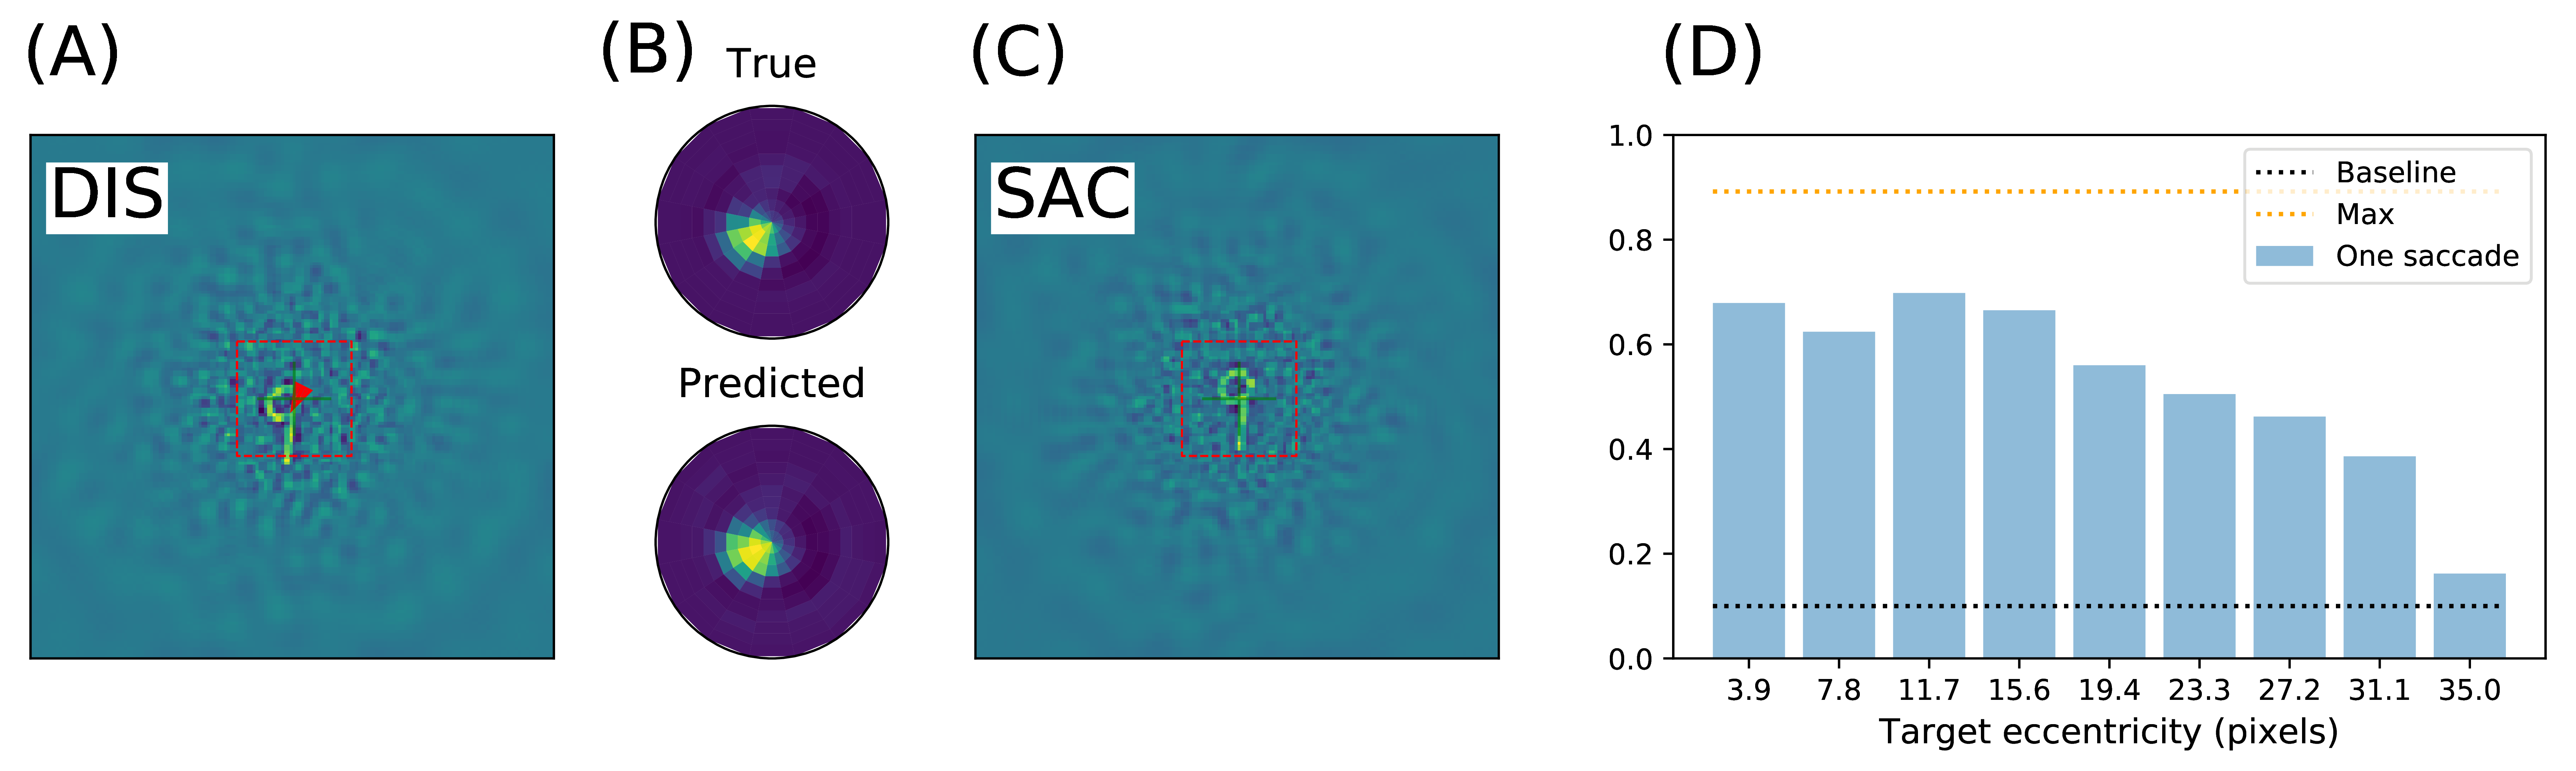

In [16]:
from IPython.display import Image
Image('{figname}.png'.format(figname=figname))

In [17]:
!ls  -l {figname}*

-rw-r--r--  1 laurentperrinet  staff  1093323 Mar 15 13:55 ../paper/fig_result.jpg
-rw-r--r--@ 1 laurentperrinet  staff    65270 Mar 15 13:55 ../paper/fig_result.pdf
-rw-r--r--  1 laurentperrinet  staff   399249 Mar 15 13:55 ../paper/fig_result.png


## Version used

In [18]:
%load_ext version_information
%version_information numpy, shl_scripts

Software versions
Python 3.7.2 64bit [Clang 10.0.0 (clang-1000.11.45.5)]
IPython 7.3.0
OS Darwin 18.2.0 x86_64 i386 64bit
numpy 1.16.2
shl_scripts 20171221
Fri Mar 15 13:55:17 2019 CET